# Following the low level tutorial guide
This code is currently looking at this IRIS observation:

DST flare watch coordination, 2014-10-25 14:58:28-18:00:56

OBS 3880106953: Large sit-and-stare

https://www.lmsal.com/hek/hcr?cmd=view-event&event-id=ivo%3A%2F%2Fsot.lmsal.com%2FVOEvent%23VOEvent_IRIS_20141025_145828_3880106953_2014-10-25T14%3A58%3A282014-10-25T14%3A58%3A28.xml

In [1]:
# untarring code
#import tarfile
#tar = tarfile.open("iris_l2_20180102_153155_3610108077_raster.tar.gz")
#tar.extractall()
#tar.close()

In [2]:
%matplotlib inline
import gzip
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
# Set up some default matplotlib options
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

## RASTER FILES

In [3]:
# opens the IRIS fits file
sp = fits.open("20141025raster.fits")

In [4]:
# doublecheck what type of observation we have
hd = sp[0].header
hd['OBS_DESC']

'Large sit-and-stare 0.3x120 1s  C II   Mg II h/k   Mg II w Deep x 4'

In [5]:
# show the full header
#hd

In [6]:
# check the different datasets stored in the file
print(len(sp))
print(hd['NWIN'])
print(sp.info())

6
3
Filename: 20141025raster.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   ()      
  1                1 ImageHDU        33   (1027, 387, 2040)   int16 (rescales to float32)   
  2                1 ImageHDU        33   (1020, 387, 2040)   int16 (rescales to float32)   
  3                1 ImageHDU        33   (1015, 387, 2040)   int16 (rescales to float32)   
  4                1 ImageHDU        54   (47, 2040)   float64   
  5                1 TableHDU        53   2040R x 7C   [A10, A10, A4, A10, A4, A66, A66]   
None


In [7]:
# print name & index of each spectral line
print('Window. Name      : wave start - wave end\n')
for i in range(hd['NWIN']):
    win = str(i + 1)
    print('{0}. {1:15}: {2:.2f} - {3:.2f} Å'
          ''.format(win, hd['TDESC' + win], hd['TWMIN' + win], hd['TWMAX' + win]))

Window. Name      : wave start - wave end

1. C II 1336      : 1331.69 - 1358.32 Å
2. Si IV 1394     : 1380.77 - 1406.70 Å
3. Mg II k 2796   : 2783.32 - 2834.96 Å


In [8]:
# Set which line to look at
line_num = 2

In [9]:
# The first axis is the number of raster positions (or time if sit and stare), 
# the second axis the y coordinate (space along slit), and the last axis is the wavelength.
sp[line_num].data.shape

(2040, 387, 1020)

In [10]:
sp[line_num].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                 1020 /                                                
NAXIS2  =                  387 /                                                
NAXIS3  =                 2040 /                                                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
CDELT1  =      0.0254399999976 /                                                
CDELT2  =             0.332700 /                                                
CDELT3  =        0.00000000000 /                                                
CRPIX1  =              1.00000 /                                                
CRPIX2  =              194.0

In [11]:
# changing this value to 1 was necessary to use the wcs transformation code (something to do with making sure the transformation matrix is non-singular)
# however I don't think we even need actual Sun coords anwyway
sp[line_num].header['CDELT3']=1

In [12]:
# Thid code is sorcery I don't understand that gets us the wavelength information
wcs = WCS(sp[line_num].header)
m_to_nm = 1e9  # convert wavelength to nm
nwave = sp[line_num].data.shape[2]
wavelength = wcs.all_pix2world(np.arange(nwave), [0.], [0.], 0)[0] * m_to_nm

In [13]:
print(wavelength)

[138.07720679 138.07975079 138.08229479 ... 140.66445479 140.66699879
 140.66954279]


Text(0, 0.5, 'Intensity (DN)')

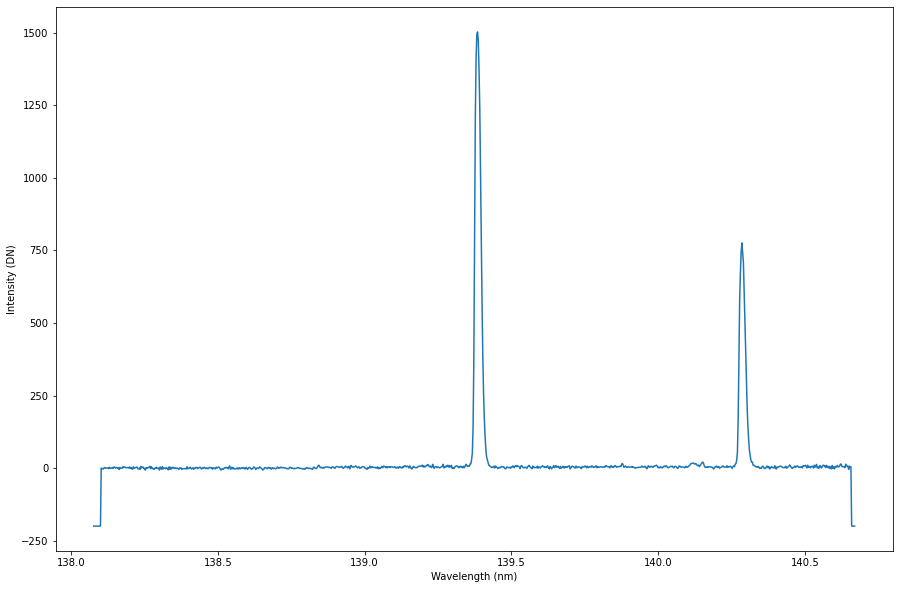

In [14]:
# plot the spectral line profile at a specific point in the image
plt.plot(wavelength, sp[line_num].data[1000, 320])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (DN)")

# Spectroheliograms

In [15]:
# The position of the 1393.757 Å line
line_index_1394 = np.argmin(np.abs(wavelength - 139.3757))
print(line_index_1394)

510


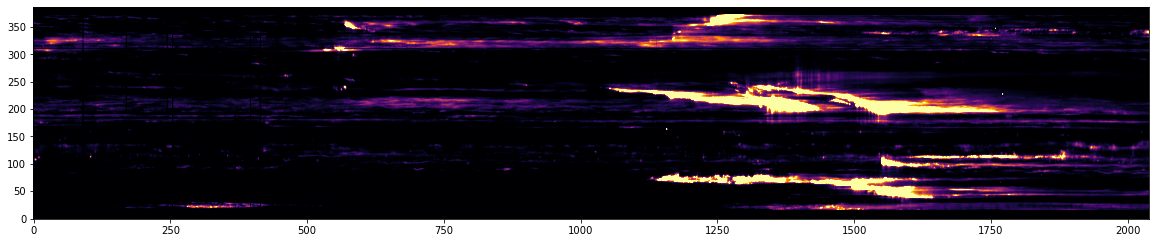

In [16]:
# plot the brightness in the 1394 line. y axis = slit position, x axis = time
plt.figure(figsize=(20, 20))
plt.imshow(sp[line_num].data[..., line_index_1394].T, vmin=100, vmax=2000)

## Getting a spectral line profile

(139.3, 140.9, -10.0, 1250.0)

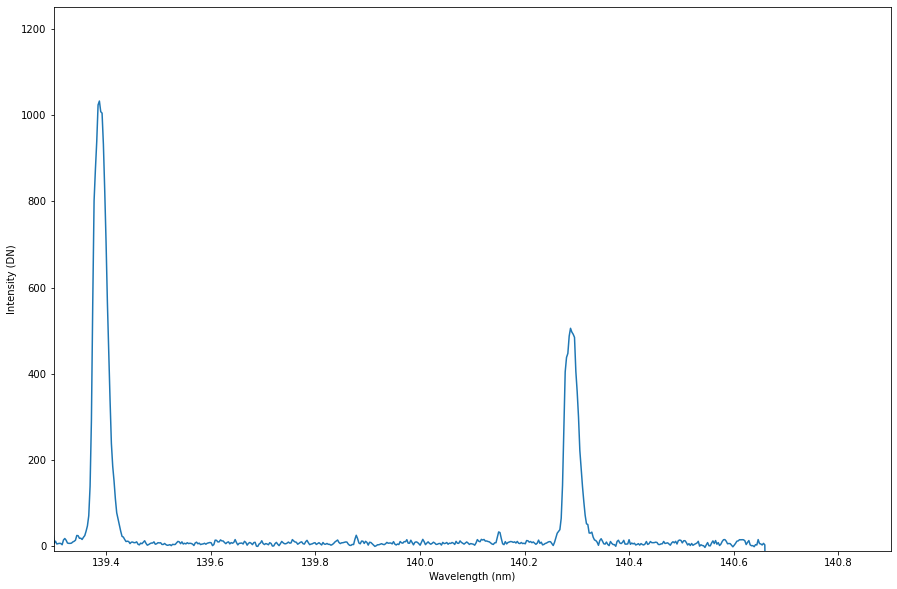

In [17]:
plt.plot(wavelength, sp[line_num].data[1250, 350])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (DN)")
plt.axis([139.3, 140.9, -10, 1250])  # cut off -200 bit

In [18]:
# Let's get the flare data
temp_data = sp[line_num].data

In [19]:
temp_data.shape

(2040, 387, 1020)

In [20]:
# create an array containing the timestamps of the data (as strings)
time_diff = sp[-2].data[:, sp[-2].header['TIME']]
times_temp = np.datetime64(hd['DATE_OBS']) + time_diff * np.timedelta64(1, 's')
times_string = np.datetime_as_string(times_temp)
times = []
for letter in np.arange(0, len(times_string)):
    times.append(times_string[letter][11:-4])

In [21]:
#print(times)
print(len(times))

2040


In [22]:
print(temp_data[0, :, 0].shape)

(387,)


# Tracking the time evolution of the silicon lines

Here we have the time evolution of the intensity of the 1394 line at a specified slit position.

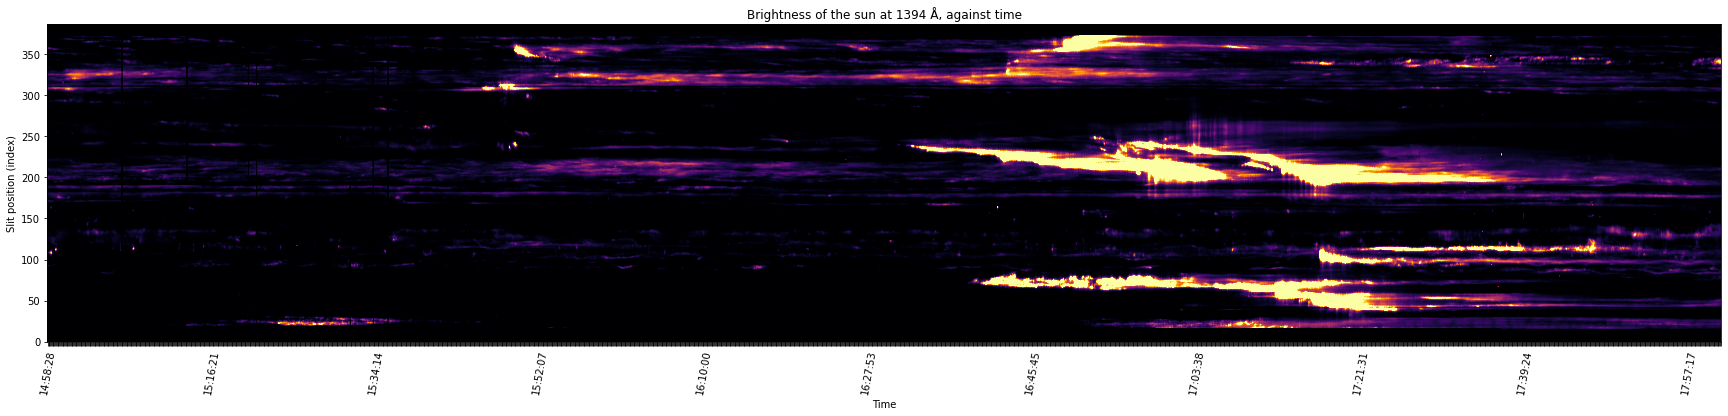

In [23]:
plt.figure(figsize=(30, 20))
plt.title('Brightness of the sun at 1394 Å, against time')
plt.xlabel('Time')
plt.ylabel('Slit position (index)')
plt.xticks(range(len(times)), times, rotation = 80)
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::200]))
for label in temp:
    label.set_visible(False)
plt.imshow(temp_data[..., line_index_1394].T, vmin=100, vmax=2000)

In [24]:
# position of the 1402 line
line_index_1403 = np.argmin(np.abs(wavelength - 140.2772))
print(line_index_1403)
# What slit position are we considering (i.e. the y coordinate in the following spectroheliograph)?
slit_pos = 345

865


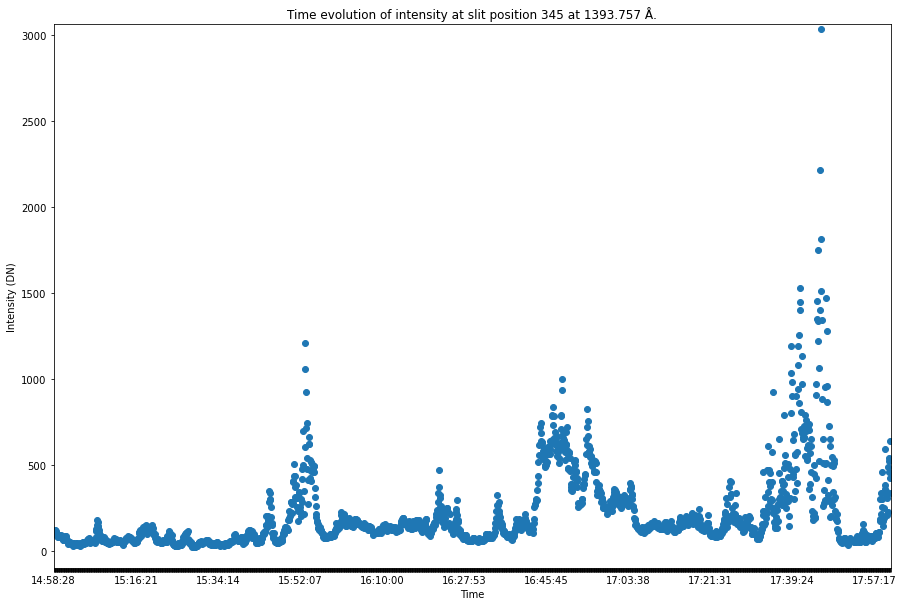

In [25]:
plt.figure(figsize=[15,10])
plt.title('Time evolution of intensity at slit position ' + str(slit_pos) + ' at 1393.757 Å.')
plt.scatter(times, temp_data[:, slit_pos, line_index_1394], linewidth=1)
plt.axis([min(times), max(times), -100, max(temp_data[:, slit_pos, line_index_1394])+30])
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::200]))
for label in temp:
    label.set_visible(False)
plt.xlabel('Time')
plt.ylabel('Intensity (DN)')
plt.show()

Here we have the time evolution of the intensity @ 1402.77 Angstrom line at a specified slit position.

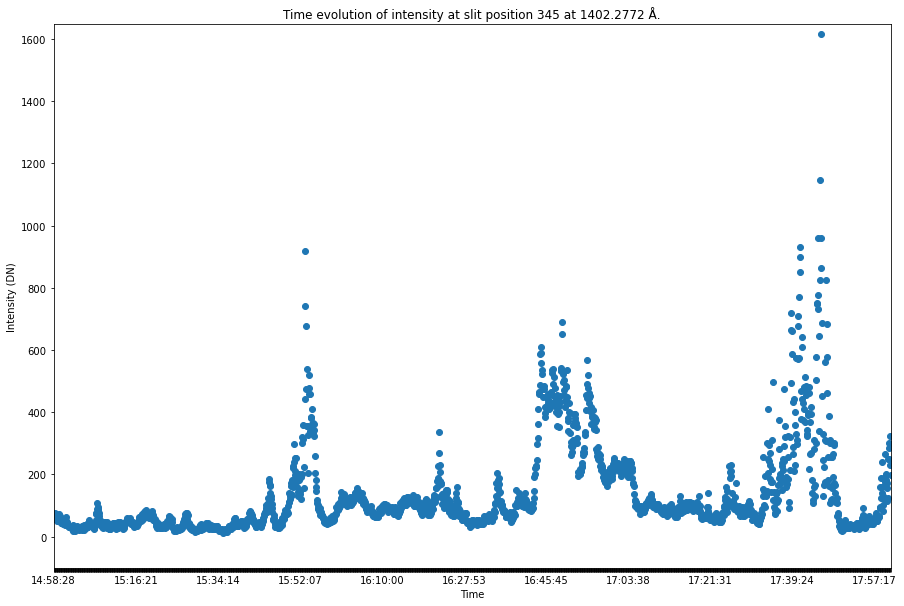

In [26]:
plt.figure(figsize=[15,10])
plt.title('Time evolution of intensity at slit position ' + str(slit_pos) + ' at 1402.2772 Å.')
plt.scatter(times, temp_data[:, slit_pos, line_index_1403], linewidth=1)
plt.axis([min(times), max(times), -100, max(temp_data[:, slit_pos, line_index_1403])+30])
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::200]))
for label in temp:
    label.set_visible(False)
plt.xlabel('Time')
plt.ylabel('Intensity (DN)')
plt.show()

## Si IV intensity ratios

Here we can take the intensity ratios of the two Silicon lines at arbitrary slit positions.

In [27]:
intensity_ratio = temp_data[:, slit_pos, line_index_1394]/temp_data[:, slit_pos, line_index_1403]
print(intensity_ratio)

[1.8963964 1.5214008 1.5841584 ... 1.9667183 1.844734  1.6972362]


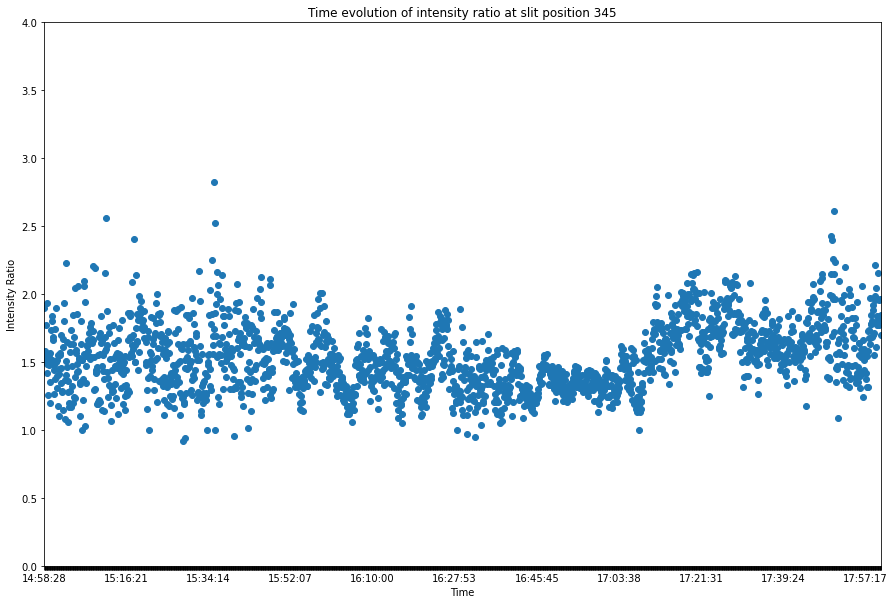

In [28]:
# Plot the time evolution of this ratio
plt.figure(figsize=[15,10])
plt.title('Time evolution of intensity ratio at slit position ' + str(slit_pos))
plt.scatter(times, intensity_ratio, linewidth=1)
plt.axis([min(times), max(times), 0, 4])
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::200]))
for label in temp:
    label.set_visible(False)
plt.xlabel('Time')
plt.ylabel('Intensity Ratio')
plt.show()

## Calculating intensity ratios in a loop

We will create an array which will be populated with intensity ratios and the corresponding 1394 A intensity.

In [29]:
# tracking down a 0 in the data
# np.count_nonzero(temp_data[:, 287:380, line_index_1403] == 0, axis=0)

In [43]:
# create the array with 100 x 2040 data points - one for each data point in the area of interest - with columms for:
# peak intensities in both lines, time and slit coordinate
# the y-coordinate will be zero-based from y = 280 on the spectroheliograph
ratio_array = np.zeros((2040, 92, 4))

ny = 0
# loop through each time point for each slit position, and store the intensity ratio & 1394 A intensity
for y in np.arange(288, 380):
    for t in np.arange(0, 2040):
        ratio_array[t, ny, 0] = temp_data[t, y, line_index_1394]
        ratio_array[t, ny, 1] = temp_data[t, y, line_index_1403]
        ratio_array[t, ny, 2] = t
        ratio_array[t, ny, 3] = y
    ny = ny + 1

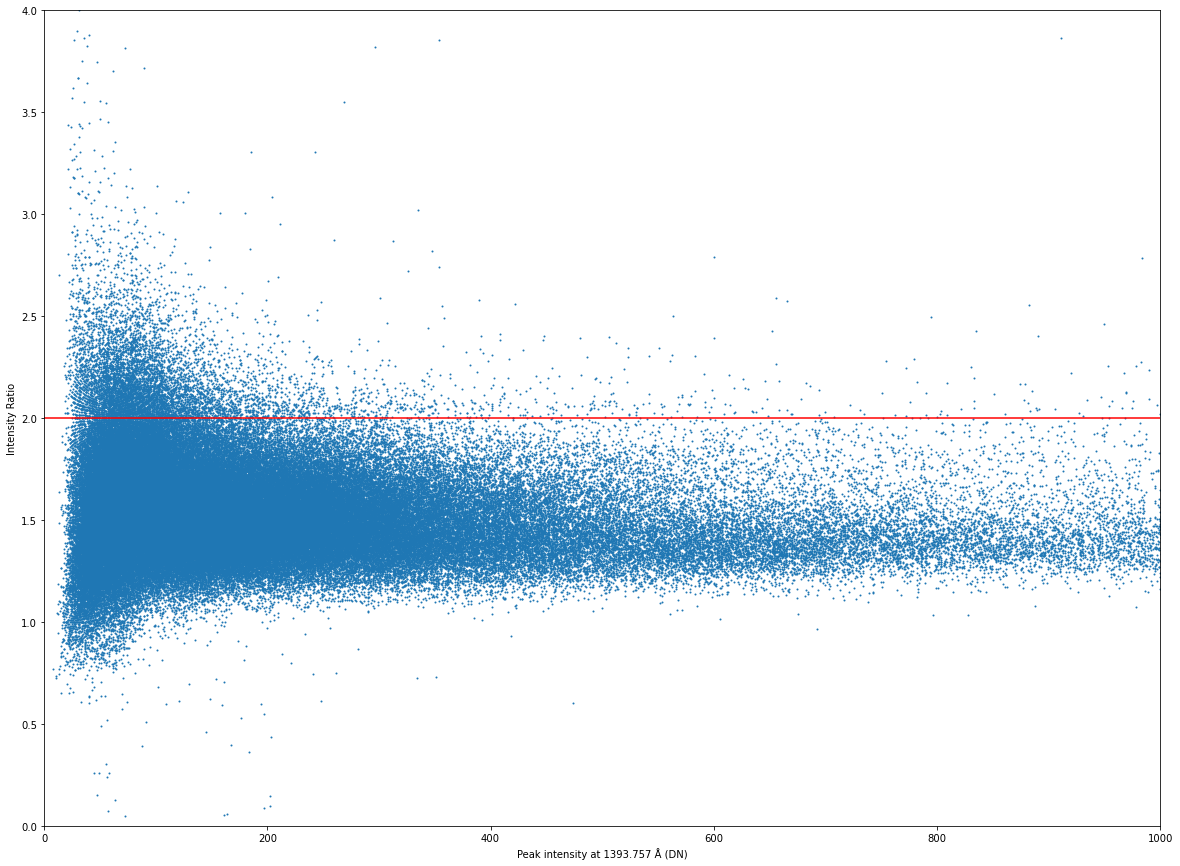

In [44]:
plt.figure(figsize=[20,15])
# plot with colourmap - comment out the unwanted plt.scatter command
#plt.scatter(ratio_array[:, :, 1], ratio_array[:, :, 0], s=1, c=ratio_array[:, :, 2], cmap='jet')
# plot without colourmap
plt.scatter(ratio_array[:, :, 0], ratio_array[:, :, 0]/ratio_array[:, :, 1], s=1)
plt.axhline(y=2, color='r', linestyle='-')
plt.axis([0, 1000, 0, 4]) # control the axes
plt.xlabel('Peak intensity at 1393.757 Å (DN)')
plt.ylabel('Intensity Ratio')
# colourbar section
#cbar = plt.colorbar()
#cbar.set_ticks([0, 510, 1020, 1530, 2039])
#cbar.set_ticklabels([times[0], times[509], times[1019], times[1529], times[2039]])
plt.show()

## Gaussian Analysis

We want to pick out data points from the above data to perform Gaussian analysis, based on chosen criteria (specific intensity ratio and intensity ranges).

### Gaussian Analysis Test

We need an idea of the background noise. Let's average across the 'quiet' section of the above data.

In [32]:
background = np.mean(sp[line_num].data[50, 320, 50:400])
background

0.16428572

In [36]:
# Test on the 1394 line - we need to extract this from the full spectral data
# we use the two line_index variables found previously, but we want to be able to select a specific wavelength range around the reference wavelength

li_1394_upper = np.argmin(np.abs(wavelength - 139.42))
li_1394_lower = np.argmin(np.abs(wavelength - 139.35))

In [37]:
test_gauss_x = wavelength[li_1394_lower:li_1394_upper]
test_gauss_y_32 = sp[line_num].data[50, 320, li_1394_lower:li_1394_upper]-background
test_gauss_y = test_gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data

Might need to use skewnorm function - documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

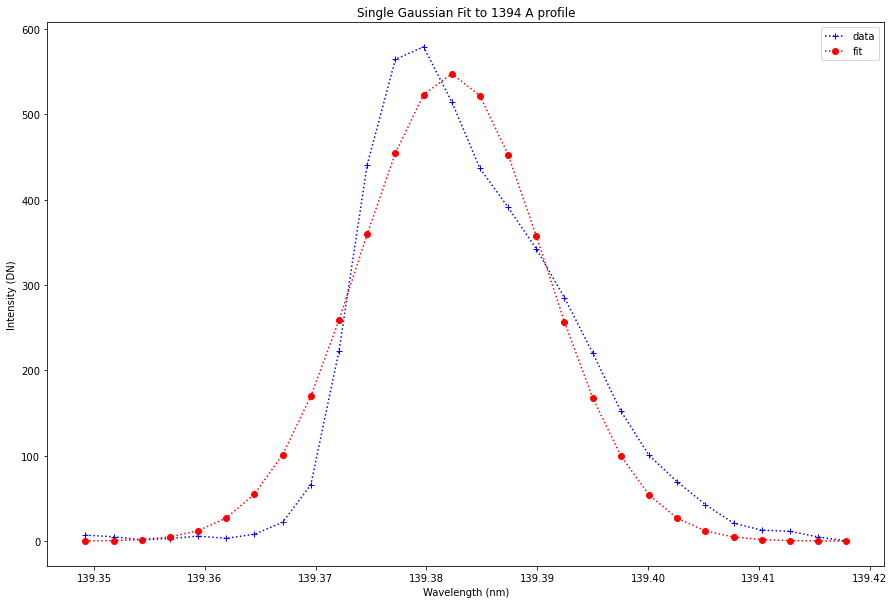

the code ran
[5.47700659e+02 1.39382252e+02 8.29292603e-03]
[[ 6.97331626e+02  1.76473266e-06 -7.03938268e-03]
 [ 1.76473266e-06  2.13181818e-07 -2.67518976e-11]
 [-7.03938268e-03 -2.67518976e-11  2.13182082e-07]]


In [38]:
# Then we can perform a Gaussian fit to the line profile
# initial guesses
mean = 139.3757
sigma = 0.01

def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# perform the Gaussian fit
popt,pcov = curve_fit(gauss,test_gauss_x,test_gauss_y, p0=[max(test_gauss_y), mean, sigma])

plt.plot(test_gauss_x,test_gauss_y,'b+:',label='data')
plt.plot(test_gauss_x,gauss(test_gauss_x,*popt),'ro:',label='fit')
plt.legend()
plt.title('Single Gaussian Fit to 1394 A profile')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (DN)')
plt.show()
print('the code ran')
print(popt)
print(pcov)